In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression

import warnings
import numpy as np
from collections import OrderedDict

from lob_data_utils import lob, db_result, overview
from lob_data_utils.svm_calculation import lob_svm

sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

In [2]:
data_length = 10000
stock = '4320'

In [3]:
df, df_cv, df_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', cv=True, length=data_length)

## Logistic

0.5822807017543858

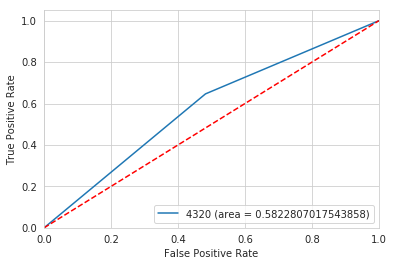

In [4]:
log_clf = lob.logistic_regression(df, 0, len(df))
pred = log_clf.predict(df_test['queue_imbalance'].values.reshape(-1, 1))
lob.plot_roc(df_test, log_clf, stock=int(stock), )

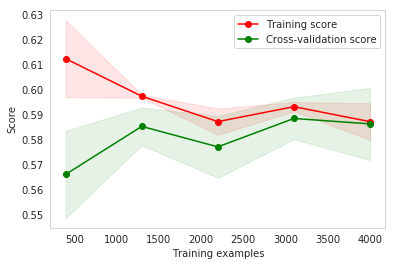

In [5]:
lob.plot_learning_curve(log_clf, df['queue_imbalance'].values.reshape(-1, 1), df['mid_price_indicator'])

## SVM

In [6]:
overview_data = overview.Overview(stock, data_length)

gammas = [0.0005, 0.005, 1, 5, 50, 500, 5000]
cs = [0.0005, 0.005, 1, 5.0, 50, 500, 1000]
coef0s = [0, 0.0005, 0.005, 1, 5, 50, 500, 5000]

df_svm_res = overview_data.write_svm_results(df, df_cv, gammas=gammas, cs=cs, coef0s=coef0s)
df_svm_res.head()

Results read from file


,Unnamed: 0,svm,c,gamma,coef0,roc_cv_score,roc_train_score
123,123,sigmoid,0.005,5000.0,50.0000,0.566140,0.586994
113,113,sigmoid,0.005,500.0,5.0000,0.565651,0.587363
91,91,sigmoid,0.005,5.0,0.0000,0.564694,0.587457
92,92,sigmoid,0.005,5.0,0.0005,0.564694,0.587457
93,93,sigmoid,0.005,5.0,0.0050,0.564694,0.587457


In [7]:
df_svm_res.head()

,Unnamed: 0,svm,c,gamma,coef0,roc_cv_score,roc_train_score
123,123,sigmoid,0.005,5000.0,50.0000,0.566140,0.586994
113,113,sigmoid,0.005,500.0,5.0000,0.565651,0.587363
91,91,sigmoid,0.005,5.0,0.0000,0.564694,0.587457
92,92,sigmoid,0.005,5.0,0.0005,0.564694,0.587457
93,93,sigmoid,0.005,5.0,0.0050,0.564694,0.587457


In [8]:
df_svm_res.sort_values(by='roc_cv_score').head()

,Unnamed: 0,svm,c,gamma,coef0,roc_cv_score,roc_train_score
312,312,sigmoid,50.0,5000.0,0.0050,0.462273,0.445684
311,311,sigmoid,50.0,5000.0,0.0005,0.462784,0.445857
310,310,sigmoid,50.0,5000.0,0.0000,0.462784,0.445857
313,313,sigmoid,50.0,5000.0,1.0000,0.467881,0.451011
374,374,sigmoid,500.0,5000.0,0.0000,0.470113,0.461988


## GDF

In [9]:
K = 50

rr = [0.01, 0.05, 0.1, 0.5, 1.0]
ss = [0.01, 0.05, 0.1, 0.5, 1.0]

Kn = 10

df_gdf_res = overview_data.write_svm_gdf(K=K, Kn=Kn, rr=rr, ss=ss)
df_gdf_res.head()

Results file does not exist yet
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.01 1 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.01 1 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.05 1 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.05 1 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.05 1 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.05 1 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.05 10 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.05 10 1
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.05 10 10
Only one class present in y_true. ROC AUC score is not defined in that case. 0.01 0.05 10 10
Only one class present in y_true. ROC AUC score is

FileNotFoundError: File b'../gaussian_filter/data_gdf/gdf_4320_len10000_r0.01_s1.0_K50.csv' does not exist

In [ ]:
len(df_gdf_res)

## GDF with logistic reg

In [ ]:
K = 50
length = data_length
rr = [0.01, 0.05, 0.1, 0.5, 1]
ss = [0.01, 0.05, 0.1, 0.5, 1]
Cs = [1, 10, 100, 1000, 10000]
Kn = 10

df_gdf_log_res = overview_data.write_gdf_logistic(K=K, Kn=Kn, rr=rr, ss=ss, Cs=Cs)
df_gdf_log_res.head()

## Results on test

In [ ]:
best_gdf_res = df_gdf_res.sort_values(by='roc_cv_score', ascending=False).iloc[0]
best_gdf_log_res = df_gdf_log_res.sort_values(by='roc_cv_score', ascending=False).iloc[0]
best_svm_sig_res = df_svm_res[df_svm_res['svm'] == 'sigmoid'].sort_values(
    by='roc_cv_score', ascending=False).iloc[0]
best_svm_rbf_res = df_svm_res[df_svm_res['svm'] == 'rbf'].sort_values(
    by='roc_cv_score', ascending=False).iloc[0]          
best_svm_lin_res = df_svm_res[df_svm_res['svm'] == 'linear'].sort_values(
    by='roc_cv_score', ascending=False).iloc[0]
res_dict = OrderedDict({
    'gdf_svm': best_gdf_res,
    'gdf_log': best_gdf_log_res,
    'svm_rbf': best_svm_rbf_res,
    'svm_lin': best_svm_lin_res,
    'svm_sig': best_svm_sig_res,
})

In [ ]:
list(res_dict.values())[0]

In [ ]:
def gdf_svm_classification(df, K, C=1000, gamma=1):
    gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
    clf = SVC(kernel='rbf', C=C, gamma=gamma)
    X = df.loc[:, gdf_columns]
    y = df['mid_price_indicator'].values.reshape(-1, 1)
    y[0] = 0
    clf.fit(X, y)
    return clf

filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(stock, length, best_gdf_res['r'], best_gdf_res['s'], 
                                             int(best_gdf_res['K']))
dfs, dfs_cv, dfs_test = lob.load_prepared_data(
    filename, data_dir='../gaussian_filter/data_gdf/', cv=True, length=length)
svm_gdf_clf = gdf_svm_classification(dfs, K, C=best_gdf_res['c'], gamma=best_gdf_res['gamma'])
gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
pred_test = svm_gdf_clf.predict(dfs_test.loc[:, gdf_columns])
roc_test = roc_auc_score(pred_test, dfs_test['mid_price_indicator'])
best_gdf_res['roc_test_score'] = roc_test
roc_test

In [ ]:
def gdf_log_classification(df, K, C=1000):
    gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
    clf = LogisticRegression(C=C)
    X = df.loc[:, gdf_columns]
    y = df['mid_price_indicator'].values.reshape(-1, 1)
    y[0] = 0
    clf.fit(X, y)
    return clf

filename = 'gdf_{}_len{}_r{}_s{}_K{}'.format(
    stock, length, best_gdf_log_res['r'], best_gdf_log_res['s'], int(best_gdf_log_res['K']))
dfs, dfs_cv, dfs_test = lob.load_prepared_data(
    filename, data_dir='../gaussian_filter/data_gdf/', cv=True, length=length)
svm_gdf_clf = gdf_log_classification(dfs, K, C=best_gdf_res['c'])
gdf_columns = ['gdf_' + str(i) for i in range(0, K)]
pred_test = svm_gdf_clf.predict(dfs_test.loc[:, gdf_columns])
roc_test = roc_auc_score(pred_test, dfs_test['mid_price_indicator'])
best_gdf_log_res['roc_test_score'] = roc_test
roc_test

In [ ]:
df, df_cv, df_test = lob.load_prepared_data(
    stock, data_dir='../queue_imbalance/data/prepared', cv=True, length=data_length)

svm = lob_svm.SVMRbf(stock, df, c=best_svm_rbf_res['c'], gamma=best_svm_rbf_res['gamma'], data_length=data_length)
roc_test = svm.predict(df_test, 'test', check=False)
best_svm_rbf_res['roc_test_score'] = roc_test

svm = lob_svm.SVMSigmoid(stock, df, c=best_svm_sig_res['c'], 
                         gamma=best_svm_sig_res['gamma'], coef0=best_svm_sig_res['coef0'])
roc_test = svm.predict(df_test, 'test', check=False)
best_svm_sig_res['roc_test_score'] = roc_test

svm = lob_svm.SVMLinear(stock, df, c=best_svm_lin_res['c'])
roc_test = svm.predict(df_test, 'test', check=False)
best_svm_lin_res['roc_test_score'] = roc_test

In [ ]:
res = []
for k, v in res_dict.items():
    dd = v.to_dict()
    dd['type'] = k
    res.append(dd)
df_res = pd.DataFrame(res)

df_res[['roc_train_score', 'roc_cv_score', 'roc_test_score']].plot(kind='bar', figsize=(8, 8))
d = plt.xticks(list(range(len(res_dict.keys()))), list(res_dict.keys()))
plt.legend(loc='upper right')

In [ ]:
print(res_dict['gdf_svm'])